# A2: Image classification in the brower

In this assignment, you will gain real-world experience with image classification on small datasets - a common scenario in practice. There are three parts.

1. First, you will train a model on a small existing dataset.

2. Next,  you will collect a small dataset yourself. Of course, in practice there often isn’t  a dataset available for tasks you care about, so it’s valuable to get a feel for this process. You will train a small model from scratch, then use data augmentation to improve accuracy.

3. Finally, you will deploy your model from part two in a webpage using TensorFlow.js. A user will be able to upload a photo, and your model will classify it. 

## Instructions

Please complete this notebook by searching for **"TODO"**.

## Submission instructions

Please submit this assignment on CourseWorks by uploading a Jupyter notebook that includes saved output. If you are working in Colab, you can prepare your notebook for submission by ensuring that runs end-to-end, then saving and downloading it:

1. ```Runtime -> Restart and run all```
1. ```File -> Save```
1. ```File -> Download.ipynb```

Note: you will need to include a URL to your webpage for part 3, see the final TODO at the bottom of this notebook.

## Setup instructions
1. If you are running this notebook in Colab, make sure a GPU is enabled (```Edit -> Notebook settings -> Hardware accelerator```).

2. Create a GitHub Pages repo by following the instructions at https://pages.github.com/. You can use this to upload your webpage after getting it running locally.

In [1]:
try:
  %tensorflow_version 2.x # enable TF 2.x in Colab
except Exception:
  pass

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `2.x # enable TF 2.x in Colab`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [2]:
import tensorflow as tf
print(tf.__version__)

2.1.0


## 1a) Flowers

In this part of the assignment, you will train a model on a small existing dataset (flowers).

In [0]:
import IPython.display as display
import matplotlib.pyplot as plt
import random
import time

from tensorflow.keras import datasets, layers, models

AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
IMG_SIZE = 192
SHUFFLE_SIZE = 1000

### Download the flowers dataset

In [4]:
import pathlib
data_root_orig = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True)
data_root = pathlib.Path(data_root_orig)
print(data_root)

228818944/228813984 [==============================] - 2s 0us/step
/root/.keras/datasets/flower_photos


### Write an input pipeline from scratch
There are several ways to load images in TensorFlow. Later in this assignment, you'll use the [Keras preprocessing utilities](https://keras.io/preprocessing/image/). For starters, though, you'll see how-to write your own using ```tf.data```, based on this [tutorial](https://www.tensorflow.org/beta/tutorials/load_data/images). This is valuable to do once (just so you can see how the nuts and bolts work) before using the higher level utils. This code is written for you as an example. Follow along and try to understand each piece.


In [5]:
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

3670

In [6]:
all_image_paths[:5]

['/root/.keras/datasets/flower_photos/tulips/3909355648_42cb3a5e09_n.jpg',
 '/root/.keras/datasets/flower_photos/sunflowers/7791014076_07a897cb85_n.jpg',
 '/root/.keras/datasets/flower_photos/tulips/3510799169_0ed6ae9669_n.jpg',
 '/root/.keras/datasets/flower_photos/tulips/16055807744_000bc07afc_m.jpg',
 '/root/.keras/datasets/flower_photos/roses/509239741_28e2cfe492_m.jpg']

### Get to know your data

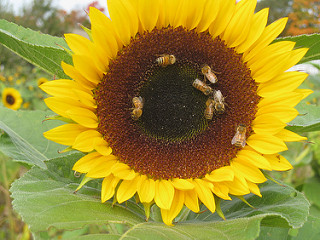

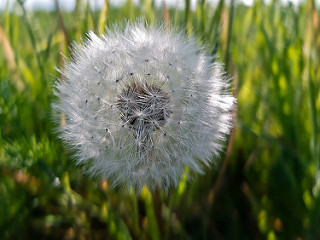

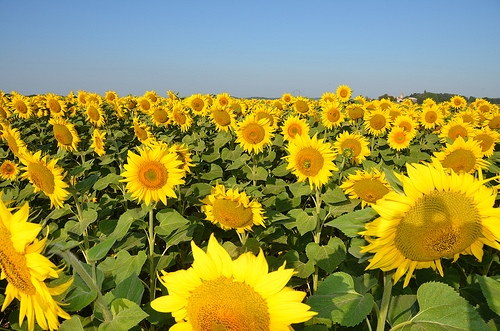

In [7]:
for n in range(3):
  image_path = random.choice(all_image_paths)
  display.display(display.Image(image_path))
  print()

### Classes are given by directory names

In [8]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [9]:
label_to_index = dict((name, index) for index, name in enumerate(label_names))
label_to_index

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

In [10]:
all_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_labels[:10])

First 10 labels indices:  [4, 3, 4, 4, 2, 0, 1, 1, 4, 4]


### Create a train/test split

In [0]:
from sklearn.model_selection import train_test_split
train_paths, test_paths, train_labels, test_labels = train_test_split(all_image_paths, all_labels)   

### Display a few images and their labels

dandelion


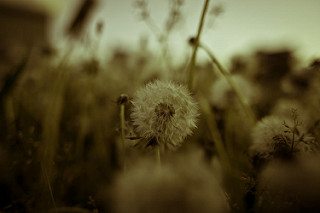


daisy


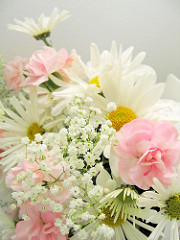


sunflowers


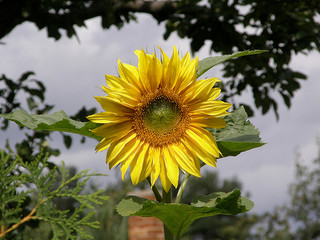

In [12]:
for n in range(3):
  i = random.randint(0,len(train_paths))
  image_path = train_paths[i]
  print(label_names[train_labels[i]])
  display.display(display.Image(image_path))
  print()

### Begin using TensorFlow ops to read and decode the images

In [13]:
img_raw = tf.io.read_file(train_paths[0])
print(repr(img_raw)[:100]+"...")

<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00\xf0\x00...


In [14]:
img_tensor = tf.image.decode_image(img_raw)
print(img_tensor.shape)
print(img_tensor.dtype)

(333, 500, 3)
<dtype: 'uint8'>


In [15]:
img_final = tf.image.resize(img_tensor, [IMG_SIZE, IMG_SIZE])
img_final = img_final / 255.0 # normalize pixel values
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())

(192, 192, 3)
0.0
1.0


### Wrap those in a function
Tip: pay careful attention to the preprocessing. When you deploy models in the browser, you will need to ensure that images are preprocessed identically in JavaScript as they are in Python.

In [0]:
def load_and_preprocess_image(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
  img /= 255.0  # normalize pixels to 0,1
  return img

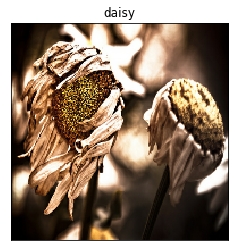

In [17]:
def show(img, label):
  plt.imshow(img)
  plt.title(label)
  plt.xticks([])
  plt.yticks([])
  print()

img_path = train_paths[0]
img = load_and_preprocess_image(img_path)
label = label_names[train_labels[0]]
show(img, label)

### Build an input pipeline to return images and labels
I realize this is complicated. The problem we're trying to solve using tf.data is performance (we want our preprocessing to run in C, but to write our code in Python). There are a bunch of advanced tricks you can do with tf.data as well (e.g. prefetching images to the GPU).

Note: although your *peak* performance can be higher, it's also very easy to make mistakes and end up with code that's super slow. Always benchmark your input pipelines before using them (shown in a bit). 

In [18]:
# a dataset that returns image paths
path_ds = tf.data.Dataset.from_tensor_slices(train_paths)
for n, img_path in enumerate(path_ds.take(4)):
  print(n, img_path)

0 tf.Tensor(b'/root/.keras/datasets/flower_photos/daisy/4432271543_01c56ca3a9.jpg', shape=(), dtype=string)
1 tf.Tensor(b'/root/.keras/datasets/flower_photos/tulips/2813658587_337eeef124_n.jpg', shape=(), dtype=string)
2 tf.Tensor(b'/root/.keras/datasets/flower_photos/tulips/15922772266_1167a06620.jpg', shape=(), dtype=string)
3 tf.Tensor(b'/root/.keras/datasets/flower_photos/sunflowers/3001533700_1c62fb8b4a_n.jpg', shape=(), dtype=string)


In [19]:
# a dataset that returns images (loaded off disk, decoded, and preprocessed)
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
for n, image in enumerate(image_ds.take(4)):
  print(n, image.shape)

0 (192, 192, 3)
1 (192, 192, 3)
2 (192, 192, 3)
3 (192, 192, 3)


In [20]:
# a dataset that returns labels
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(train_labels, tf.int64))
for label in label_ds.take(4):
  print(label_names[label.numpy()])

daisy
tulips
tulips
sunflowers


In [21]:
# a dataset that returns images and labels
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
print(image_label_ds)

<ZipDataset shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int64)>


In [22]:
for img, label in image_label_ds.take(2):
  print(img.shape, label_names[label.numpy()])

(192, 192, 3) daisy
(192, 192, 3) tulips


### Batch and shuffle
Why do we need to specify a shuffle_size parameter? tf.data works with streams (it doesn't know their length). To shuffle items, we maintain an in-memory buffer of this size.

In [23]:
ds = image_label_ds.shuffle(SHUFFLE_SIZE)
ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

for img, label in ds.take(2):
  print(img.shape, label.shape) # notice it's returning batches of data now

(32, 192, 192, 3) (32,)
(32, 192, 192, 3) (32,)


At this point, you could use the dataset above to train a model with ```model.fit(ds)``` but first, let's improve performance. As written, the dataset will load each image off disk, one at a time (super slow). Instead, we want to cache them in memory.

### Improve performance

In [0]:
# A benchmark utility to time how long it takes
# to iterate once over the entire dataset
def time_one_epoch(ds):
  start = time.time()
  batches = 0
  for i,(images,labels) in enumerate(ds):
    batches += 1
    if i % 10 == 0:
      print('.', end='')
  print()
  end = time.time()
  duration = end-start
  print("Read {} batches".format(batches))
  print("{:0.2f} Batches/s".format(batches/duration))
  print("{:0.2f} Images/s".format(BATCH_SIZE*batches/duration))
  print("Total time: {}s".format(duration))

### Use in-memory caching
This is a small dataset, so let's keep it in memory. The first time we iterate over this dataset, images will be loaded off disk, then cached. The first iteration will be quite slow, and subsequent ones will be faster. Let's show that. 

In [0]:
ds = image_label_ds.cache() # cache data in mempry
ds = ds.shuffle(SHUFFLE_SIZE)
ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

In [26]:
time_one_epoch(ds) # this will be slow

.........
Read 86 batches
19.53 Batches/s
625.00 Images/s
Total time: 4.403165578842163s


Now that the cache is built, iteration will be much faster.

In [27]:
time_one_epoch(ds) # this will be fast

.........
Read 86 batches
217.83 Batches/s
6970.47 Images/s
Total time: 0.394808292388916s


### How-to use on-disk caching

If the dataset did not fit into memory, you could use a cache file on disk, like this:

```
ds = image_label_ds.cache(filename='./cache.tf-data')
ds = ds.shuffle(buffer_size=BUFFER_SIZE)
ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
```

This can be useful to perform expensive preprocessing only once, and/or to improve file I/O (TF saves the cache file in an efficient format - it can be faster to read one large file than a bunch of small ones). For now, we'll keep it in memory.

In [0]:
# here's our final training dataset
train_ds = image_label_ds.cache()
train_ds = train_ds.shuffle(SHUFFLE_SIZE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

# let's make a test dataset as well
path_ds = tf.data.Dataset.from_tensor_slices(test_paths)
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(test_labels, tf.int64))
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
test_ds = image_label_ds.cache().batch(BATCH_SIZE)

### Finally, we have a fast pipeline ready to go, written from scratch
Now, let's define a model.

## 1b) Create a simple CNN
This is our baseline model, it will not be very accurate. You'll improve it below.

In [0]:
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', 
                        input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(layers.MaxPooling2D())

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 190, 190, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 95, 95, 16)        0         
Total params: 448
Trainable params: 448
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.add(layers.Flatten())
model.add(layers.Dense(5, activation='softmax'))

### Tip: pay attention to the size of the model
Later, when you export a model to run in the webpage, you will want a small one (in terms of the number of parameters) that downloads quickly. Notice how much more efficient convolutional layers are than the dense layers (ask yourself,why?)

### Tip: pay attention to exactly how your images are preprocessed
Later, when you run your model in a browser, you'll need to preprocess images in JavaScript in exactly the same way.

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 190, 190, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 95, 95, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 144400)            0         
_________________________________________________________________
dense (Dense)                (None, 5)                 722005    
Total params: 722,453
Trainable params: 722,453
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [34]:
# I realize we're not using a separate test set, that's fine
# for this assignment
model_history = model.fit(train_ds, validation_data=test_ds, epochs=10)

Train for 86 steps, validate for 29 steps
Epoch 1/10
86/86 [==============================] - 13s 152ms/step - loss: 1.5240 - accuracy: 0.4771 - val_loss: 1.1791 - val_accuracy: 0.5468
Epoch 2/10
86/86 [==============================] - 2s 19ms/step - loss: 0.8902 - accuracy: 0.6853 - val_loss: 1.0930 - val_accuracy: 0.5806
Epoch 3/10
86/86 [==============================] - 2s 20ms/step - loss: 0.5607 - accuracy: 0.8241 - val_loss: 1.1537 - val_accuracy: 0.5806
Epoch 4/10
86/86 [==============================] - 2s 20ms/step - loss: 0.3202 - accuracy: 0.9110 - val_loss: 1.1752 - val_accuracy: 0.5861
Epoch 5/10
86/86 [==============================] - 2s 20ms/step - loss: 0.1762 - accuracy: 0.9644 - val_loss: 1.3360 - val_accuracy: 0.5414
Epoch 6/10
86/86 [==============================] - 2s 20ms/step - loss: 0.1033 - accuracy: 0.9836 - val_loss: 1.3524 - val_accuracy: 0.5730
Epoch 7/10
86/86 [==============================] - 2s 20ms/step - loss: 0.0620 - accuracy: 0.9924 - val_loss:

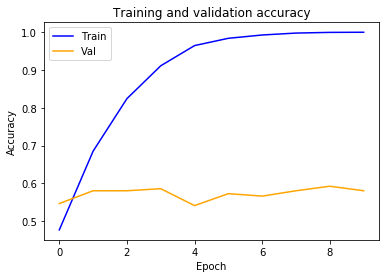

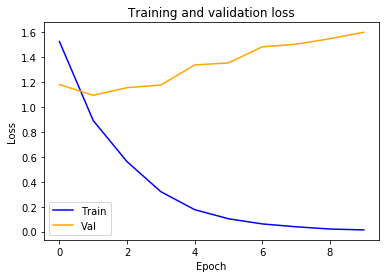

In [35]:
def plot(history):
  # The history object contains results on the training and test
  # sets for each epoch
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get the number of epochs
    epochs = range(len(acc))

    plt.title('Training and validation accuracy')
    plt.plot(epochs, acc, color='blue', label='Train')
    plt.plot(epochs, val_acc, color='orange', label='Val')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    _ = plt.figure()
    plt.title('Training and validation loss')
    plt.plot(epochs, loss, color='blue', label='Train')
    plt.plot(epochs, val_loss, color='orange', label='Val')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
plot(model_history)

The base model does not behave well, reaching an validation accuracy of aroung 0.56. And there is slightly model over-fitting since validation loss increases with the increase of epoch.

### Make predictions on a single image
Tip: models are implemented to make predictions on batches of images for efficiency. This means that to make a prediction on a single image, you'll need to first wrap it in a batch. The syntax can feel a little unusual at first, but gets easier with time.

In [36]:
# load an image off disk
img_index = 0
img = load_and_preprocess_image(train_paths[img_index])

print(img.shape) # before

#########
## TODO: your code here
## use tf.expand_dims to create an empty batch dimension
## the starting image shape is (192, 192, 3)
## you want it to be (1, 192, 192, 3)
## that's read as "a batch of 1 image, with 192 rows, 192 cols, 
## and 3 color channels"

#########
im_batch = tf.expand_dims(img, 0) # YOUR CODE HERE, use tf.expand_dims

print(im_batch.shape) # after

# make predictions
batch_pred = model.predict(im_batch) # returns a list of predictions
pred = batch_pred[0] 

print("Prediction", label_names[tf.argmax(pred)])
print("Actual", label_names[train_labels[img_index]])

(192, 192, 3)
(1, 192, 192, 3)
Prediction daisy
Actual daisy


### TODO: Improve accuracy
In the code cell below, write a new model that's more accurate than the baseline above. Define and train your model, and create plots of loss / accuracy as a function of epochs. Try to train your model to high accuracy, without overfitting. For this assignment, it is not necessary to build a super accurate model (just experiment a bit and try to improve over the baseline).

In [0]:
# TODO: your code here
model1 = models.Sequential([
    # keras needs  (Rows x Cols x Channels)
    # Convolutional Layers
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu',input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.4),
    
    # Dense Layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='softmax')  #output 5 classes
])


In [38]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 190, 190, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 95, 95, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 95, 95, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 93, 93, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 46, 46, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 44, 44, 128)      

In [0]:
model1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [40]:
# I realize we're not using a separate test set, that's fine
# for this assignment
model1_history  = model1.fit(train_ds, validation_data=test_ds, epochs=10)

Train for 86 steps, validate for 29 steps
Epoch 1/10
86/86 [==============================] - 6s 68ms/step - loss: 1.7813 - accuracy: 0.2206 - val_loss: 1.5862 - val_accuracy: 0.2353
Epoch 2/10
86/86 [==============================] - 5s 54ms/step - loss: 1.4993 - accuracy: 0.3412 - val_loss: 1.3320 - val_accuracy: 0.4542
Epoch 3/10
86/86 [==============================] - 5s 54ms/step - loss: 1.3225 - accuracy: 0.4270 - val_loss: 1.2432 - val_accuracy: 0.4651
Epoch 4/10
86/86 [==============================] - 5s 53ms/step - loss: 1.2762 - accuracy: 0.4651 - val_loss: 1.2181 - val_accuracy: 0.4815
Epoch 5/10
86/86 [==============================] - 5s 53ms/step - loss: 1.2128 - accuracy: 0.4836 - val_loss: 1.1875 - val_accuracy: 0.4423
Epoch 6/10
86/86 [==============================] - 5s 53ms/step - loss: 1.1565 - accuracy: 0.5105 - val_loss: 1.1407 - val_accuracy: 0.5000
Epoch 7/10
86/86 [==============================] - 5s 53ms/step - loss: 1.0661 - accuracy: 0.5596 - val_loss: 1

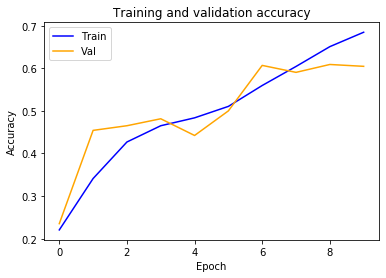

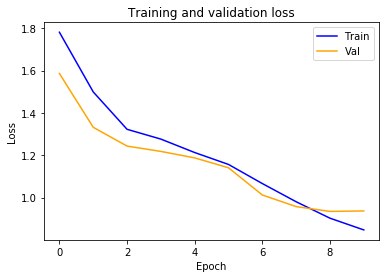

In [41]:
plot(model1_history)

We can see that the model accuracy on validation set is now 0.64, higher than the 0.51 in the baseline model. And the validation set is following the track of traing set on loss and accuracy, showing no significant over-fitting.

## 1c) Practice deploying your flowers classifier using TensorFlow.js
In the final part of the assignment, you'll export the model you build to recognize landmarks on Columbia's campus, and get it working in the browser. If you're new to JavaScript (as most of us are), the mechanics will be difficult at first. 

Let's practice by exporting your flowers classifier, and getting it working with TensorFlow.js (the starter code provided is written to work with flowers model).

### Save your model

In [0]:
model1.save("/content/flower_model.h5")

In [43]:
!ls -lha

total 183M
drwxr-xr-x 1 root root 4.0K Feb 24 14:44 .
drwxr-xr-x 1 root root 4.0K Feb 24 14:42 ..
drwxr-xr-x 1 root root 4.0K Feb 19 17:12 .config
-rw-r--r-- 1 root root 183M Feb 24 14:44 flower_model.h5
drwxr-xr-x 1 root root 4.0K Feb  5 18:37 sample_data


### Download your saved model to your local machine

In [0]:
from google.colab import files
files.download("/content/flower_model.h5")

### Visit notebook #2 (a2-2.ipynb on CourseWorks) to convert your saved model into to TensorFlow.js format

Follow the instructions there to prepare a webpage to run your flowers model in the browser. Once you have that working, you can continue with the rest of this assignment in this notebook.

## 1d) Classify flowers using transfer learning

In this part of the assignment, you'll use transfer learning to take advantage of a large pretrained model. It is not necesary to deploy this part in the browser.


Read this tutorial before completing this section:
* https://www.tensorflow.org/tutorials/images/transfer_learning

In [0]:
## TODO: your code here
# Choose a pretrained model, and import the application
# See https://keras.io/applications/ for a few choices
# When you import the model, you will want to remove the 
# final dense layer that performs classification (include_top=False)
# you will also want to import weights from ImageNet,
# and you will want to specify the input shape to match your images. 

flower_base_model = tf.keras.applications.VGG19(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                               include_top=False,
                                               weights='imagenet')

In [55]:
# A hack to show you the output shape of the model
for image_batch, label_batch in train_ds.take(1):
   pass
  
feature_batch = flower_base_model(image_batch)
print(feature_batch.shape)

(32, 6, 6, 512)


In [0]:
# do not update the pretrained weights during training
# (we won't use finetuning here)
flower_base_model.trainable = False 

In [57]:
flower_base_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 192, 192, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 192, 192, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 192, 192, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 96, 96, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 96, 96, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 96, 96, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 48, 48, 128)       0     

In [0]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')

In [0]:
# build a new model reusing the pretrained base
model = tf.keras.Sequential([
  flower_base_model,
  global_average_layer,
  prediction_layer
])

In [0]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [61]:
transfer_model = model.fit(train_ds, validation_data=test_ds, epochs=10)

Train for 86 steps, validate for 29 steps
Epoch 1/10
86/86 [==============================] - 16s 186ms/step - loss: 1.4417 - accuracy: 0.4371 - val_loss: 1.3132 - val_accuracy: 0.5861
Epoch 2/10
86/86 [==============================] - 16s 188ms/step - loss: 1.1815 - accuracy: 0.6403 - val_loss: 1.1348 - val_accuracy: 0.6580
Epoch 3/10
86/86 [==============================] - 16s 190ms/step - loss: 1.0346 - accuracy: 0.6817 - val_loss: 1.0316 - val_accuracy: 0.6819
Epoch 4/10
86/86 [==============================] - 16s 184ms/step - loss: 0.9421 - accuracy: 0.7035 - val_loss: 0.9681 - val_accuracy: 0.6885
Epoch 5/10
86/86 [==============================] - 16s 181ms/step - loss: 0.8806 - accuracy: 0.7180 - val_loss: 0.9160 - val_accuracy: 0.6972
Epoch 6/10
86/86 [==============================] - 16s 182ms/step - loss: 0.8320 - accuracy: 0.7271 - val_loss: 0.8695 - val_accuracy: 0.7244
Epoch 7/10
86/86 [==============================] - 16s 185ms/step - loss: 0.7925 - accuracy: 0.7369

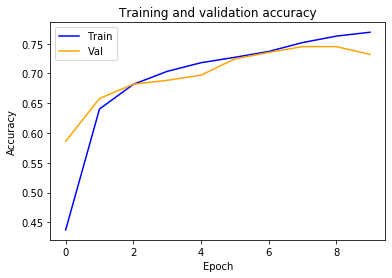

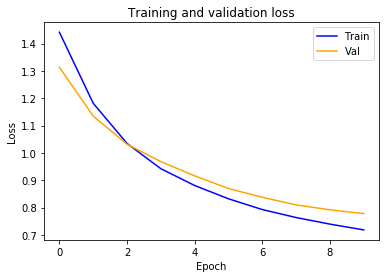

In [62]:
plot(transfer_model)

Using transfer learning on VGG19, we can see the flower identification model has improved a lot on its validation accuracy and avoids overfitting on the training set.

## 2a) Recognize landmarks on Columbia's campus

In this part of the assignment, you will train a model to recognize landmarks (famous places, like the [Alma Mater sculpture](https://en.wikipedia.org/wiki/Alma_Mater_(New_York_sculpture), or Butler library) on Columbia’s campus. Instead of tf.data, you will gain experience with the higher level Keras utilties. You will also experiment with data augmentation to increase the effective size of your dataset.

Starter code is not provided for this part of the assignment. You should base your work off the following Keras notebook, which works identically in TF2 (the only thing you'll need to change is the imports, an example of correct imports is given below).

* https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.2-using-convnets-with-small-datasets.ipynb

Here are steps you should complete.

1. Collect a dataset of at least three landmarks. Your dataset should include at least 50 images of each landmark in train, and 50 in validation (using more images is fine). Randomly shuffle your data to create these splits. You do not need to use a separate test set in this assignment.

 You will need to upload your dataset to Colab in order to train a model. To do so, you can either upload it using the file browser (slow and tedious, you'll need to repeat that if your runtime is reset), or (better) you can upload your dataset to Google Drive, then mount your drive as a filesystem in Colab (View -> Table of contents -> Code snippets -> search for "drive"). This will enable you to access the contents of your drive with commands like `!ls /gdrive`. As a another option, you could upload your dataset to a cloud provider or your Columbia account, then download it similarly to flowers at the top of this notebook.
 
1. Write a model to classify your data. Try to train a small model in terms of the number of parameters (you do not need to use transfer learning). 

1. Show predictions on several images.

1. Use data augmentation, see if this helps to improve accuracy.

1. Produce plots of accuracy / loss as a function of epochs. Determine the right place to stop training without overfitting.

When you have a reasonably accurate model, proceed to the next step. There are no guidelines for accuracy, try to build something you feel works well, given the small amount of data you have.

__Collect data and split training and  test sets__

In [63]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
!ls "/content/drive/My Drive/columbia_landmarks_raw"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/
alma  hamiton  lion  thinker


In [0]:
import random
import os, shutil
import numpy as np
# dataset was uncompressed
original_dataset_dir = '/content/drive/My Drive/columbia_landmarks_raw'

# The directory where we will
# store our smaller dataset
base_dir = '/content/drive/My Drive/columbia_landmarks_processed'
try:
  os.mkdir(base_dir)
except:
  pass

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train') 
test_dir = os.path.join(base_dir, 'test') 
try:
  os.mkdir(train_dir)
  os.mkdir(test_dir)
except:
  pass

N_alma = len([name for name in os.listdir(original_dataset_dir+'/alma')])
N_hamiton = len([name for name in os.listdir(original_dataset_dir+'/hamiton')])
N_lion = len([name for name in os.listdir(original_dataset_dir+'/lion')])
N_thinker = len([name for name in os.listdir(original_dataset_dir+'/thinker')])

# Directory with our training pictures on different landmarks
train_alma_dir = os.path.join(train_dir, 'alma')
train_hamiton_dir = os.path.join(train_dir, 'hamiton')
train_lion_dir = os.path.join(train_dir, 'lion')
train_thinker_dir = os.path.join(train_dir, 'thinker')
try:
  os.mkdir(train_alma_dir)
  os.mkdir(train_hamiton_dir)
  os.mkdir(train_lion_dir)
  os.mkdir(train_thinker_dir)
except:
  pass

# Directory with our testing pictures on different landmarks
test_alma_dir = os.path.join(test_dir, 'alma')
test_hamiton_dir = os.path.join(test_dir, 'hamiton')
test_lion_dir = os.path.join(test_dir, 'lion')
test_thinker_dir = os.path.join(test_dir, 'thinker')
try:
  os.mkdir(test_alma_dir)
  os.mkdir(test_hamiton_dir)
  os.mkdir(test_lion_dir)
  os.mkdir(test_thinker_dir)
except:
  pass

In [0]:
# Shuffle the data and Copy them to train_alma_dir and test_alma_dir
fnames = np.array(os.listdir(original_dataset_dir+"/alma"))
index = np.arange(len(fnames))
np.random.shuffle(index)
train_fnames, test_fnames = fnames[index[:len(index)//2+2]], fnames[index[len(index)//2+2:]]
for fname in train_fnames:
    src = os.path.join(original_dataset_dir+'/alma/', fname)
    dst = os.path.join(train_alma_dir+"/", fname)
    shutil.copyfile(src, dst)
for fname in test_fnames:
    src = os.path.join(original_dataset_dir+'/alma/', fname)
    dst = os.path.join(test_alma_dir+"/", fname)
    shutil.copyfile(src, dst)

# Shuffle the data and Copy them to train_hamiton_dir and test_hamiton_dir
fnames = np.array(os.listdir(original_dataset_dir+"/hamiton"))
index = np.arange(len(fnames))
np.random.shuffle(index)
train_fnames, test_fnames = fnames[index[:len(index)//2+2]], fnames[index[len(index)//2+2:]]
for fname in train_fnames:
    src = os.path.join(original_dataset_dir+'/hamiton/', fname)
    dst = os.path.join(train_hamiton_dir+"/", fname)
    shutil.copyfile(src, dst)
for fname in test_fnames:
    src = os.path.join(original_dataset_dir+'/hamiton/', fname)
    dst = os.path.join(test_hamiton_dir+"/", fname)
    shutil.copyfile(src, dst) 
    
# Shuffle the data and Copy them to train_lion_dir and test_lion_dir
fnames = np.array(os.listdir(original_dataset_dir+"/lion"))
index = np.arange(len(fnames))
np.random.shuffle(index)
train_fnames, test_fnames = fnames[index[:len(index)//2+2]], fnames[index[len(index)//2+2:]]
for fname in train_fnames:
    src = os.path.join(original_dataset_dir+'/lion/', fname)
    dst = os.path.join(train_lion_dir+"/", fname)
    shutil.copyfile(src, dst)
for fname in test_fnames:
    src = os.path.join(original_dataset_dir+'/lion/', fname)
    dst = os.path.join(test_lion_dir+"/", fname)
    shutil.copyfile(src, dst) 


# Shuffle the data and Copy them to train_thinker_dir and test_thinker_dir
fnames = np.array(os.listdir(original_dataset_dir+"/thinker"))
index = np.arange(len(fnames))
np.random.shuffle(index)
train_fnames, test_fnames = fnames[index[:len(index)//2+2]], fnames[index[len(index)//2+2:]]
for fname in train_fnames:
    src = os.path.join(original_dataset_dir+'/thinker/', fname)
    dst = os.path.join(train_thinker_dir+"/", fname)
    shutil.copyfile(src, dst)
for fname in test_fnames:
    src = os.path.join(original_dataset_dir+'/thinker/', fname)
    dst = os.path.join(test_thinker_dir+"/", fname)
    shutil.copyfile(src, dst)

In [66]:
#test if train, test files are split successfully
print('total training alma images:', len(os.listdir(train_alma_dir)))
print('total testing alma images:', len(os.listdir(test_alma_dir)))
print('total training hamiton images:', len(os.listdir(train_hamiton_dir)))
print('total testing hamiton images:', len(os.listdir(test_hamiton_dir)))
print('total training lion images:', len(os.listdir(train_lion_dir)))
print('total testing lion images:', len(os.listdir(test_lion_dir)))
print('total training thinker images:', len(os.listdir(train_thinker_dir)))
print('total testing thinker images:', len(os.listdir(test_thinker_dir)))

total training alma images: 133
total testing alma images: 130
total training hamiton images: 80
total testing hamiton images: 77
total training lion images: 121
total testing lion images: 117
total training thinker images: 130
total testing thinker images: 126


 __Data Preprocessing__

 - Read the picture files
 - Decode the JPEG content to RBG grids of pixels.
 - Convert these into floating point tensors.
 - Rescale the pixel values (between 0 and 255) to the [0, 1] interval (as you know, neural networks prefer to deal with small input values).

In [0]:
#set new image size
BATCH_SIZE = 32
IMG_SIZE = 192

In [75]:
# Example code showing the correct imports
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# You should use the keras preprocessing utilities here instead of tf.data
# Here's an example of how to use them with the flowers dataset
# You will need to add data augmentation

###
# TODO: your code for 2a here.
###

train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(IMG_SIZE, IMG_SIZE), # All images will be resized
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=42,
        class_mode="sparse")

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(IMG_SIZE, IMG_SIZE), # All images will be resized
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=42,
        class_mode="sparse") #


Found 457 images belonging to 4 classes.
Found 440 images belonging to 4 classes.


In [77]:
for data_batch,labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (32, 192, 192, 3)
labels batch shape: (32,)


 __Train base model__

In [0]:
landmark_base_model = models.Sequential([
    # keras needs  (Rows x Cols x Channels)
    # Convolutional Layers
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu',input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Dense Layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')  #output 4 classes
])


In [92]:
landmark_base_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 190, 190, 32)      896       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 95, 95, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 93, 93, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 44, 44, 128)       73856     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 22, 22, 128)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 20, 20, 128)      

In [0]:
landmark_base_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [94]:
#use fit_generator now to pass data_generator (from directory)
landmark_base_history = landmark_base_model.fit_generator(
      train_generator,
      epochs=20,
      validation_data=test_generator)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 15 steps, validate for 14 steps
Epoch 1/20
15/15 [==============================] - 14s 909ms/step - loss: 1.4032 - accuracy: 0.2495 - val_loss: 1.3694 - val_accuracy: 0.2818
Epoch 2/20
15/15 [==============================] - 14s 903ms/step - loss: 1.3741 - accuracy: 0.2779 - val_loss: 1.3615 - val_accuracy: 0.2932
Epoch 3/20
15/15 [==============================] - 13s 880ms/step - loss: 1.3553 - accuracy: 0.3173 - val_loss: 1.3525 - val_accuracy: 0.3273
Epoch 4/20
15/15 [==============================] - 13s 880ms/step - loss: 1.2903 - accuracy: 0.3676 - val_loss: 1.1949 - val_accuracy: 0.4773
Epoch 5/20
15/15 [==============================] - 13s 878ms/step - loss: 1.2210 - accuracy: 0.4530 - val_loss: 1.1280 - val_accuracy: 0.5182
Epoch 6/20
15/15 [==============================] - 13s 887ms/step - loss: 1.1350 - accuracy: 0.5142 - val_loss: 0.9914 - val_accuracy: 0.5818
Epoch 7/20
15/15 [==============================] 

In [0]:
#save model
landmark_base_model.save('landmark_base_model.h5')

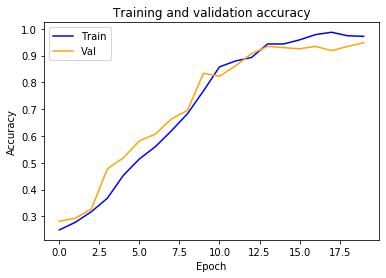

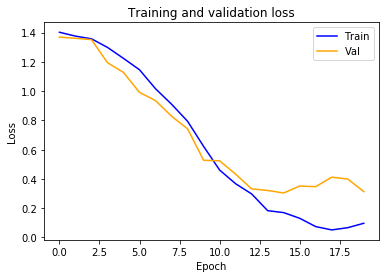

In [96]:
plot(landmark_base_history)

The base model for landmark indentification has relative great estimation, reaching an 93% accuracy on validation dataset. But there are still slightly over-fitting on the dataset with epochs increasing, since the validation loss starts to rise a little bit when epoch is larger than 13. Next we consider using data augmentation to help train a more stable model without overfitting.

__Data Augmentation__

Data augmentation generates more training data from existing training samples, by "augmenting" the samples via a number of random transformations that yield believable-looking images. At training time, it ensures our model never see the exact same picture twice. This method helps the model get more exposure to various data aspects and thus generalize better.

In [0]:
datagen = ImageDataGenerator(
      #rotation_range is a value in degrees (0-180), a range within which to randomly rotate pictures.
      rotation_range=25,  
      #width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
      width_shift_range=0.1,
      height_shift_range=0.1,
      #shear_range is for randomly applying shearing transformations.
      shear_range=0.1,
      #zoom_range is for randomly zooming inside pictures. horizontal_flip is for randomly flipping half of the images horizontally -- relevant when there are no assumptions of horizontal asymmetry (e.g. real-world pictures).
      zoom_range=0.1,
      #horizontal_flip=True,
      #fill_mode is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.
      fill_mode='nearest')

 - Visualize our augmented image

Using TensorFlow backend.


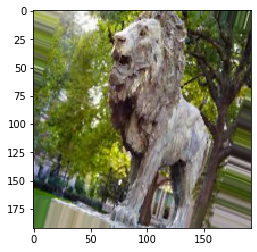

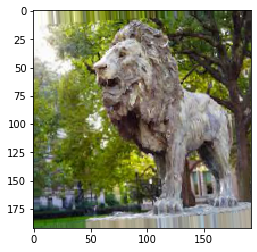

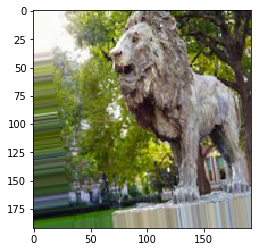

In [99]:
from keras.preprocessing import image
fnames = [os.path.join(train_lion_dir, fname) for fname in os.listdir(train_lion_dir)]
# We pick one image to "augment", read, resize and reshape it
img_path = fnames[8]
img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
x = image.img_to_array(img) # Convert it to numpy array
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 3 == 0:
        break

plt.show()

__Train augmented model__

In [100]:
landmark_augment_model = models.Sequential([
    # keras needs  (Rows x Cols x Channels)
    # Convolutional Layers
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu',input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Dense Layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')  #output 4 classes
])

landmark_augment_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
landmark_augment_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 190, 190, 32)      896       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 95, 95, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 93, 93, 64)        18496     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 44, 44, 128)       73856     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 22, 22, 128)       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 20, 20, 256)      

In [104]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    #horizontal_flip=True
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(IMG_SIZE, IMG_SIZE), # All images will be resized
        batch_size=BATCH_SIZE,
        class_mode="sparse")

# Note that the validation and test data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(IMG_SIZE, IMG_SIZE), # All images will be resized
        batch_size=BATCH_SIZE,
        class_mode="sparse")


Found 457 images belonging to 4 classes.
Found 440 images belonging to 4 classes.


In [105]:
landmark_augment_history = landmark_augment_model.fit_generator(
      train_generator,
      epochs=50,
      validation_data=test_generator)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 15 steps, validate for 14 steps
Epoch 1/50
15/15 [==============================] - 17s 1s/step - loss: 1.4120 - accuracy: 0.2341 - val_loss: 1.3704 - val_accuracy: 0.2591
Epoch 2/50
15/15 [==============================] - 17s 1s/step - loss: 1.3765 - accuracy: 0.2845 - val_loss: 1.3708 - val_accuracy: 0.2864
Epoch 3/50
15/15 [==============================] - 16s 1s/step - loss: 1.3663 - accuracy: 0.2976 - val_loss: 1.3496 - val_accuracy: 0.4023
Epoch 4/50
15/15 [==============================] - 16s 1s/step - loss: 1.3424 - accuracy: 0.3435 - val_loss: 1.3576 - val_accuracy: 0.3136
Epoch 5/50
15/15 [==============================] - 16s 1s/step - loss: 1.3650 - accuracy: 0.3020 - val_loss: 1.3124 - val_accuracy: 0.4591
Epoch 6/50
15/15 [==============================] - 16s 1s/step - loss: 1.3344 - accuracy: 0.3589 - val_loss: 1.2442 - val_accuracy: 0.4886
Epoch 7/50
15/15 [==============================] - 16s 1s/step - lo

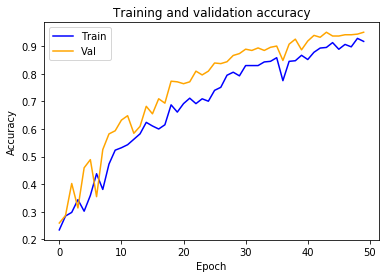

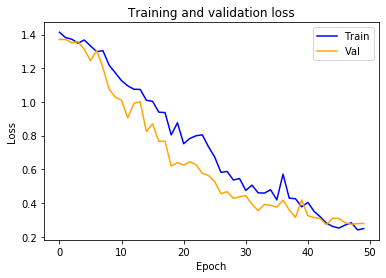

In [107]:
plot(landmark_augment_history)

According to data augmentation, we can see the model has improved a lot on accuracy. It now reaches an validation accuracy of around 95%, which is a 2% relative improvement over the non-augumented model . The validation curves are more closely tracking the training curves and outperform the training accuracy and loss most of the time, showing no overfitting and stable estimation. 

In [0]:
landmark_augment_model.save("landmark_augment_model.h5")

In [108]:
!ls -lha

total 83M
drwxr-xr-x 1 root root 4.0K Feb 24 16:04 .
drwxr-xr-x 1 root root 4.0K Feb 24 14:42 ..
drwxr-xr-x 1 root root 4.0K Feb 19 17:12 .config
drwx------ 4 root root 4.0K Feb 24 14:52 drive
drwxr-xr-x 2 root root 4.0K Feb 24 15:19 .ipynb_checkpoints
-rw-r--r-- 1 root root  43M Feb 24 16:04 landmark_augment_model.h5
-rw-r--r-- 1 root root  41M Feb 24 15:26 landmark_base_model.h5
drwxr-xr-x 1 root root 4.0K Feb  5 18:37 sample_data


In [0]:
files.download("/content/landmark_augment_model.h5")

## 2b) Run your model in the browser
Save and download your model, and head to notebook two again. After you've finished creating a webpage, upload it to GitHub Pages (or your Columbia account), list the URL here, save your assignment, and submit your assignment. You may not need to make many changes to the starter code, but pay attention to the preprocessing, number of output classes, image size, etc.

In [0]:
# TODO: list your URL here. 
# If you are unable to get it working in GitHub pages, you can also 
# submit a screenshot of your model running locally in a browser for
# partial credit.

# https://github.com/foevee/AppliedDeepLearning